In [ ]:
import numpy as np
import pandas as pd
import jieba.posseg as pseg
import os
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from multiprocessing import cpu_count, Pool
from sklearn.model_selection import train_test_split
from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

In [ ]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)
if os.path.isdir("/content/"):
    TrainCSV = '/content/train.csv'
    TestCSV = '/content/test.csv'
    TokenTrainCSV = "/content/tokenized_train.csv"
    TokenTestCSV = "/content/tokenized_test.csv"
else:
    TrainCSV = '/content/train.csv'
    TestCSV = '/content/test.csv'
    TokenTrainCSV = None

train = pd.read_csv(TrainCSV,encoding = "utf-8")
test = pd.read_csv(TestCSV,encoding = "utf-8")

In [ ]:
TrainDF = pd.DataFrame(train)
TrainDF.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [ ]:
TestDF = pd.DataFrame(test)
TestDF.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en
0,321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...
1,321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...
2,321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...
3,321193,167564,160994,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,A message from Saddam Hussein after he was cap...,The hanging Saddam is a surrogate? This man's ...
4,321191,167564,15084,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,A message from Saddam Hussein after he was cap...,Chinese loquat loquat plaster in America? Pure...


In [ ]:
train.shape

(320552, 8)

In [ ]:
train.columns

Index(['id', 'tid1', 'tid2', 'title1_zh', 'title2_zh', 'title1_en',
       'title2_en', 'label'],
      dtype='object')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320552 entries, 0 to 320551
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         320552 non-null  int64 
 1   tid1       320552 non-null  int64 
 2   tid2       320552 non-null  int64 
 3   title1_zh  320552 non-null  object
 4   title2_zh  320545 non-null  object
 5   title1_en  320552 non-null  object
 6   title2_en  320552 non-null  object
 7   label      320552 non-null  object
dtypes: int64(3), object(5)
memory usage: 19.6+ MB


## **Preprocessing**

In [ ]:
train.drop(['id','tid1', 'tid2','title1_zh', 'title2_zh'], axis=1, inplace=True)

In [ ]:
train.head(3)

,title1_en,title2_en,label
0,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated


In [ ]:
train.isnull().sum()

title1_en    0
title2_en    0
label        0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


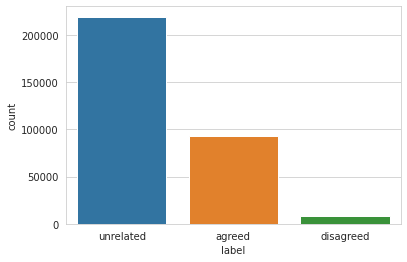

In [ ]:
sns.set_style("whitegrid")
sns.countplot(train['label'])

In [ ]:
train.dropna()

,title1_en,title2_en,label
0,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed
...,...,...,...
320547,egypt 's presidential election failed to win m...,West Media Exposing Tallahlach has been recomm...,unrelated
320548,egypt 's presidential election failed to win m...,Salah agent's dishonest rumour: rumour with ba...,unrelated
320549,egypt 's presidential election failed to win m...,Rumor has it that Egypt is very united and the...,unrelated
320550,egypt 's presidential election failed to win m...,"False rumors, Egypt Football Association Chair...",unrelated


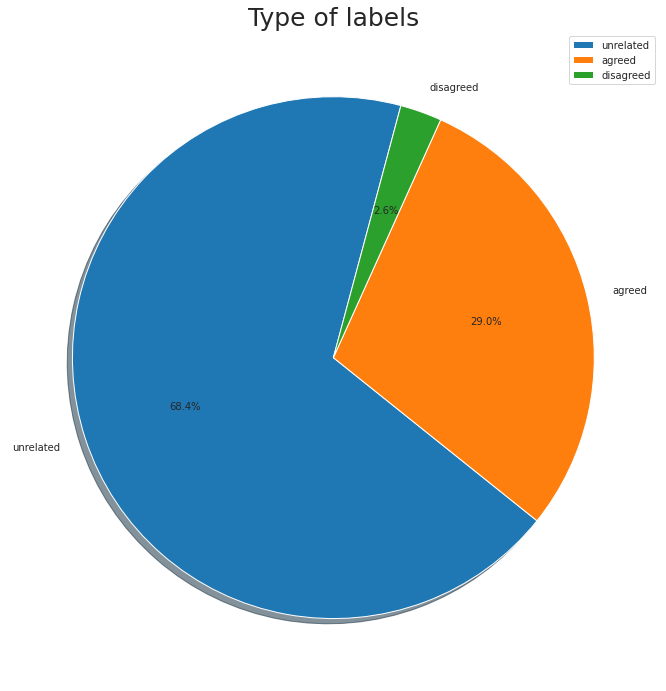

In [ ]:
train['label'].value_counts().plot.pie(figsize = (15,12), startangle = 75,autopct = "%.1f%%",shadow=True)
plt.title('Type of labels', fontsize = 25)
plt.axis('off')
plt.legend()
plt.show()

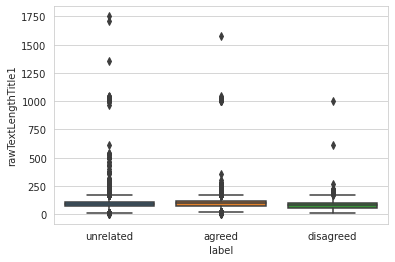

In [ ]:
TrainDF['rawTextLengthTitle1'] = train['title1_en'].apply(lambda x: 0 if pd.isna(x) else len(x))
sns.boxplot(y='rawTextLengthTitle1', x='label', data=TrainDF)
plt.show()

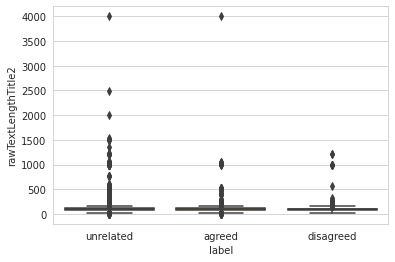

In [ ]:
TrainDF['rawTextLengthTitle2'] = train['title2_en'].apply(lambda x: 0 if pd.isna(x) else len(x))
sns.boxplot(y='rawTextLengthTitle2', x='label', data=TrainDF, palette="Set1_r")
plt.show()

In [ ]:
def preprocessing(documents):
    for document in documents.columns:
        documents[document] = documents[document].replace(r'[^\w\s]+', '')
        documents[document] = documents[document].apply(lambda doc:  re.sub(r'\s+[a-zA-Z]\s+', ' ', str(doc)))
        documents[document] = documents[document].apply(lambda doc:  re.sub(r'\s+[a-zA-Z]\s+', ' ', str(doc)))
        documents[document] = documents[document].apply(lambda doc:  re.sub(r'\s+', ' ', str(doc) , flags=re.I))
        documents[document] = documents[document].apply(lambda doc: doc.strip())
        documents[document] = documents[document].apply(lambda doc: doc.lower())
        documents[document] = documents[document].apply(lambda doc: doc.replace('\n', ''))
        

In [ ]:
preprocessing(train)  

In [ ]:
train

,title1_en,title2_en,label
0,there are two new old-age insurance benefits f...,"police disprove ""bird's nest congress each per...",unrelated
1,"""if you do not come to shenzhen, sooner or lat...",shenzhen's gdp outstrips hong kong? shenzhen s...,unrelated
2,"""if you do not come to shenzhen, sooner or lat...",the gdp overtopped hong kong? shenzhen clarifi...,unrelated
3,"""if you do not come to shenzhen, sooner or lat...",shenzhen's gdp topped hong kong last year? she...,unrelated
4,"""how to discriminate oil from gutter oil by me...",it took 30 years of cooking oil to know that o...,agreed
...,...,...,...
320547,egypt 's presidential election failed to win m...,west media exposing tallahlach has been recomm...,unrelated
320548,egypt 's presidential election failed to win m...,salah agent's dishonest rumour: rumour with ba...,unrelated
320549,egypt 's presidential election failed to win m...,rumor has it that egypt is very united and the...,unrelated
320550,egypt 's presidential election failed to win m...,"false rumors, egypt football association chair...",unrelated


In [ ]:
nltk.download('stopwords')
nltk.download('punkt');
nltk.download('wordnet');
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
stopWords = stopwords.words('english')

In [ ]:
stopWords[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [ ]:
def removingStopWords(documents):
    print(documents.columns)
    for document in documents.columns:
        documents[document] = documents[document].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))
        

In [ ]:
removingStopWords(train)

Index(['title1_en', 'title2_en', 'label'], dtype='object')


In [ ]:
train

,title1_en,title2_en,label
0,two new old-age insurance benefits old people ...,"police disprove ""bird's nest congress person g...",unrelated
1,"""if come shenzhen, sooner later son also come....",shenzhen's gdp outstrips hong kong? shenzhen s...,unrelated
2,"""if come shenzhen, sooner later son also come....",gdp overtopped hong kong? shenzhen clarified: ...,unrelated
3,"""if come shenzhen, sooner later son also come....",shenzhen's gdp topped hong kong last year? she...,unrelated
4,"""how discriminate oil gutter oil means garlic.",took 30 years cooking oil know one piece garli...,agreed
...,...,...,...
320547,egypt 's presidential election failed win mill...,west media exposing tallahlach recommended bar...,unrelated
320548,egypt 's presidential election failed win mill...,salah agent's dishonest rumour: rumour barcelona,unrelated
320549,egypt 's presidential election failed win mill...,rumor egypt united differences us.,unrelated
320550,egypt 's presidential election failed win mill...,"false rumors, egypt football association chair...",unrelated


In [ ]:
text = 'There are two new old-age insurance benefits'
TextWords = pseg.cut(text)
[TextWords for TextWords in TextWords]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 3.108 seconds.
Prefix dict has been built successfully.


[pair('There', 'eng'),
 pair(' ', 'x'),
 pair('are', 'eng'),
 pair(' ', 'x'),
 pair('two', 'eng'),
 pair(' ', 'x'),
 pair('new', 'eng'),
 pair(' ', 'x'),
 pair('old', 'eng'),
 pair('-', 'x'),
 pair('age', 'eng'),
 pair(' ', 'x'),
 pair('insurance', 'eng'),
 pair(' ', 'x'),
 pair('benefits', 'eng')]

In [ ]:
def MergerFunction(data, res):
    assert((data.index == res.index).all(), 'Data Merge Failed!')
def MultiProcessing(data, func):
    ProcessorCores = partitions = cpu_count()
    SplitData = np.array_split(data, partitions)
    MultipleJobsPerProcess = Pool(ProcessorCores)
    res = pd.concat(MultipleJobsPerProcess.map(func, SplitData))
    MultipleJobsPerProcess.close()
    MultipleJobsPerProcess.join()
    MergerFunction(data, res)
    return res
def TokenizerFunction(text):
    TextWords = pseg.cut(text)
    return ' '.join([
        TextWords for TextWords, flag in TextWords if flag != 'x'])
def TokenProcess(data):
    res = data.apply(TokenizerFunction)
    return res

<ipython-input-22-e353f0c727d3>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((data.index == res.index).all(), 'Data Merge Failed!')


In [ ]:
if os.path.exists(TokenTrainCSV):
    print("Preparing the Tokenized Train Data (CSV)!")
    train = pd.read_csv(TokenTrainCSV, index_col='id')
else:
    print("Training Started!")
    train['title1_tokenized'] = MultiProcessing(train.loc[:, 'title1_en'], TokenProcess)
    train['title2_tokenized'] = MultiProcessing(train.loc[:, 'title2_en'], TokenProcess)
    train.to_csv('TrainTokens.csv',index=True)

Training Started!


Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 3.764 seconds.
Prefix dict has been built successfully.
Dumping model to file cache /tmp/jieba.cache
Loading model cost 7.201 seconds.
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.508 seconds.
Prefix dict has been built successfully.
Loading model cost 1.439 seconds.
Prefix dict has been built successfully.


In [ ]:
train.loc[:, ["title1_en", "title1_tokenized"]].head(10)

,title1_en,title1_tokenized
0,two new old-age insurance benefits old people ...,two new old age insurance benefits old people ...
1,"""if come shenzhen, sooner later son also come....",if come shenzhen sooner later son also come . ...
2,"""if come shenzhen, sooner later son also come....",if come shenzhen sooner later son also come . ...
3,"""if come shenzhen, sooner later son also come....",if come shenzhen sooner later son also come . ...
4,"""how discriminate oil gutter oil means garlic.",how discriminate oil gutter oil means garlic .
5,"""if come shenzhen, sooner later son also come....",if come shenzhen sooner later son also come . ...
6,"""if eat durian, kill eat wrongly!""",if eat durian kill eat wrongly
7,"""if come shenzhen, sooner later son also come....",if come shenzhen sooner later son also come . ...
8,"""frog frog? fertility test! let's play"" jewel "".""",frog frog fertility test let play jewel
9,"""how discriminate oil gutter oil means garlic.",how discriminate oil gutter oil means garlic .


In [ ]:
train.loc[:, ["title2_en", "title2_tokenized"]].head(10)


,title2_en,title2_tokenized
0,"police disprove ""bird's nest congress person g...",police disprove bird nest congress person gets...
1,shenzhen's gdp outstrips hong kong? shenzhen s...,shenzhen gdp outstrips hong kong shenzhen stat...
2,gdp overtopped hong kong? shenzhen clarified: ...,gdp overtopped hong kong shenzhen clarified li...
3,shenzhen's gdp topped hong kong last year? she...,shenzhen gdp topped hong kong last year shenzh...
4,took 30 years cooking oil know one piece garli...,took 30 years cooking oil know one piece garli...
5,shenzhen's gdp overtakes hong kong? bureau sta...,shenzhen gdp overtakes hong kong bureau statis...
6,"durian can't eat anything, coffee, heart disea...",durian can eat anything coffee heart disease .
7,shenzhen's gdp outpaces hong kong? defending r...,shenzhen gdp outpaces hong kong defending rumo...
8,"store xianning contains ""cotton""? multi-agency...",store xianning contains cotton multi agency as...
9,single piece garlic spot gutter oil? come on! ...,single piece garlic spot gutter oil come on fo...


In [ ]:
train.fillna('UNKNOWN', inplace=True)

## **LSTM Implementation!**

**vectorizing texts**

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)

In [ ]:
x1Corpus = train.title1_tokenized
x2Corpus = train.title2_tokenized
Corpus = pd.concat([x1Corpus, x2Corpus])
Corpus.shape

(641104,)

In [ ]:
pd.DataFrame(Corpus.iloc[:5],columns=['Corpus Text'])

,Corpus Text
0,two new old age insurance benefits old people ...
1,if come shenzhen sooner later son also come . ...
2,if come shenzhen sooner later son also come . ...
3,if come shenzhen sooner later son also come . ...
4,how discriminate oil gutter oil means garlic .


In [ ]:
Corpus.isna().any()


False

**update the internal vocabulary for the texts list**

In [ ]:
tokenizer.fit_on_texts(Corpus)
X1Train = tokenizer.texts_to_sequences(x1Corpus)
X2Train = tokenizer.texts_to_sequences(x2Corpus)

In [ ]:
for TrainTokenSequence in X1Train[:1]:
    print([tokenizer.index_word[IndexIs] for IndexIs in TrainTokenSequence])

['two', 'new', 'old', 'age', 'insurance', 'benefits', 'old', 'people', 'rural', 'areas', 'got', 'them']


**pad_sequences is used to ensure that all sequences in a list have the same length**

In [ ]:
X1Train = keras.preprocessing.sequence.pad_sequences(X1Train,maxlen=20)
X2Train = keras.preprocessing.sequence.pad_sequences(X2Train,maxlen=20)

In [ ]:
for SequenceofList in X1Train + X2Train:
    assert len(SequenceofList) == 20

**Encoding**

In [ ]:
EncodeTheLables = {'unrelated': 0,'agreed': 1,'disagreed': 2}
TrainY = train.label.apply(lambda x: EncodeTheLables[x])
TrainY = np.asarray(TrainY).astype('float32')

In [ ]:
TrainY = keras.utils.np_utils.to_categorical(TrainY)

In [ ]:
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split( X1Train, X2Train, TrainY, test_size=0.1, random_state=9527 )

In [ ]:
from keras.layers import Embedding
TopInput = Input(shape=(20,), dtype='int32')
BottomInput = Input(shape=(20,), dtype='int32')

"""Convert each word into a fixed length vector """
KerasEmbeddingLayer = Embedding(10000, 256)
TopKerasEmbeddingLayer = KerasEmbeddingLayer(TopInput)
BottomKerasEmbeddingLayer = KerasEmbeddingLayer(BottomInput)
SharedLSTM = LSTM(128)
TopOutputs = SharedLSTM(TopKerasEmbeddingLayer)
BottomOutputs = SharedLSTM(BottomKerasEmbeddingLayer)
MergedAll = concatenate([TopOutputs, BottomOutputs], axis=-1)
dense =  Dense(units=3, activation='softmax')
predictions = dense(MergedAll)
LSTMmodel = Model(inputs=[TopInput, BottomInput], outputs=predictions)
LSTMmodel.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 20, 256)      2560000     ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 lstm (LSTM)                    (None, 128)          197120      ['embedding_6[18][0]',     

**Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments**

In [ ]:
LSTMmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = LSTMmodel.fit( x=[x1_train, x2_train],  y=y_train, batch_size=10, epochs=1, validation_data=( [x1_val, x2_val], y_val), shuffle=True )

28850/28850 [==============================] - 2488s 86ms/step - loss: 0.4647 - accuracy: 0.7842 - val_loss: 0.4241 - val_accuracy: 0.8105


In [ ]:
if os.path.exists(TokenTestCSV):
    print("Now using TestToken CSV!")
    test = pd.read_csv(TokenTestCSV, index_col=0)
else:
    print("TestCSV is being used!")
    test = pd.read_csv(TestCSV, index_col=0)
    test.fillna('UNKNOWN', inplace=True)
    test['title1_tokenized'] = MultiProcessing(test.loc[:, 'title1_en'], TokenProcess)
    test['title2_tokenized'] = MultiProcessing(test.loc[:, 'title2_en'], TokenProcess)
    test.fillna('UNKNOWN', inplace=True)
test.head(3)

TestCSV is being used!


,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,title1_tokenized,title2_tokenized
id,,,,,,,,
321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...,egypt presidential election failed to win mill...,Lyon Lyon officials have denied that Felipe Fe...
321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...,message from Saddam Hussein after he was captured,The Top 10 Americans believe that the Lizard M...
321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...,Will the United States wage war on Iraq withou...,message from Saddam Hussein after he was captured


In [ ]:
X1Test = tokenizer.texts_to_sequences(test.title1_tokenized)
X2Test = tokenizer.texts_to_sequences(test.title2_tokenized)
X1Test = keras.preprocessing.sequence.pad_sequences(X1Test, maxlen=20)
X2Test = keras.preprocessing.sequence.pad_sequences(X2Test, maxlen=20)    
predictions = LSTMmodel.predict([X1Test, X2Test])

In [ ]:
predictions

array([[9.8967719e-01, 2.5508583e-03, 7.7720219e-03],
       [9.1504049e-01, 8.2216844e-02, 2.7426223e-03],
       [9.8859566e-01, 5.0038826e-03, 6.4004022e-03],
       ...,
       [9.1849363e-01, 7.4889131e-02, 6.6172355e-03],
       [9.1492802e-01, 8.4216125e-02, 8.5584028e-04],
       [6.6434872e-01, 3.3390006e-01, 1.7511578e-03]], dtype=float32)

### **MLPClassifier**

In [ ]:
x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split( X1Train, X2Train, TrainY, test_size=0.1, random_state=9527 )

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(x1_train,y_train)

predict_train = mlp.predict(x1_train)
#predict_test = mlp.predict(X_test)

In [ ]:
predict_train

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_train,predict_train))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      1.00      0.81    197388
           1       0.97      0.00      0.00     83647
           2       0.00      0.00      0.00      7461

   micro avg       0.68      0.68      0.68    288496
   macro avg       0.55      0.33      0.27    288496
weighted avg       0.75      0.68      0.56    288496
 samples avg       0.68      0.68      0.68    288496



In [ ]:
mlp.fit(x2_train,y_train)

predict_train = mlp.predict(x2_train)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_train,predict_train))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      1.00      0.81    197388
           1       0.00      0.00      0.00     83647
           2       0.00      0.00      0.00      7461

   micro avg       0.68      0.68      0.68    288496
   macro avg       0.23      0.33      0.27    288496
weighted avg       0.47      0.68      0.56    288496
 samples avg       0.68      0.68      0.68    288496



### BERT Embeddings

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

#### BERT preprocess and encoder layer

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/google/small_bert/bert_uncased_L-2_H-128_A-2/2")

In [ ]:
df=train

In [ ]:
preprocessed_text = bert_preprocess(df['title1_en'].values.tolist())
a=bert_encoder(preprocessed_text)["default"]
preprocessed_text = bert_preprocess(df['title2_en'].values.tolist())
b=bert_encoder(preprocessed_text)['pooled_output']

#### Cosine Similarity for BERT EMbeddings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
res=[]
for i in range(12000):
  res.append(cosine_similarity([a[i]],[b[i]])[0][0])

In [ ]:
df_pred = pd.cut(x=res, bins=[0, 0.7,0.9,1],labels=[0, 1,2])
print("Accuracy:",accuracy_score(df1.values.tolist(), df_pred.tolist()))

Accuracy: 0.6312


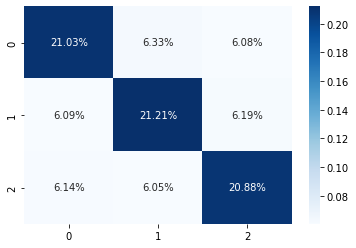

In [ ]:
cf_matrix = confusion_matrix(df1.values.tolist(), df_pred.tolist())
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
df_bert1 = pd.DataFrame(a.numpy())
df_bert2 = pd.DataFrame(b.numpy())
df = pd.concat([df_bert1, df_bert2], axis=1, join='inner')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df1,stratify=df1,test_size=0.33)

#### Support Vector Machine (SVM) for BERT EMbeddings

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.7995


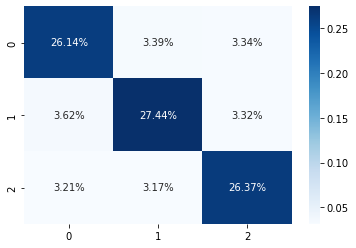

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#### Gaussian Naive Bayes for BERT EMbeddings

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.7


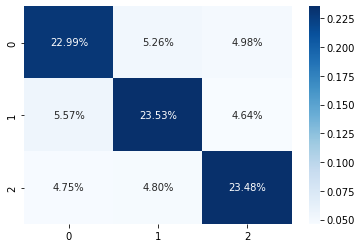

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#### Artificial Neural Network for BERT Embeddings 

In [ ]:
def ann_label(X_train, X_test, y_train, y_test):
  model = Sequential()
  model.add(Dense(128, input_dim=256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit the keras model on the dataset
  model.fit(X_train, y_train, epochs=100, batch_size=1111)
  # evaluate the keras model
  _, accuracy = model.evaluate(X_train, y_train)
  print('Accuracy: %.2f' % (accuracy*100))
  return model.predict(X_test)

In [ ]:
y_pred=ann_label(X_train, X_test, y_train, y_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.78


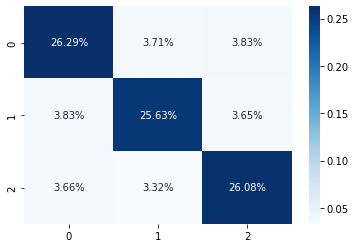

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Doc to Vector Embeddings

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [ ]:
data = df['title1_en'].values.tolist()

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

In [ ]:
max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

In [ ]:
from gensim.models.doc2vec import Doc2Vec

#to find the vector of a document which is not in training data
t_data=df['title1_en'].values.tolist()
test_data = [word_tokenize(_d.lower()) for _d in t_data]
v1=[model.infer_vector(d) for d in test_data]

t_data2=df['title2_en'].values.tolist()
test_data2 = [word_tokenize(_d.lower()) for _d in t_data2]
v2=[model.infer_vector(d) for d in test_data2]

#### Cosine Similarity for DOC to VEC embeddings

In [ ]:
res=[]
for i in range(12000):
  res.append(cosine_similarity([v1[i]],[v2[i]])[0][0])

In [ ]:
df_pred = pd.cut(x=res, bins=[0, 0.7,0.9,1],labels=[0, 1,2])
print("Accuracy:",accuracy_score(df1.values.tolist(), df_pred.tolist()))

Accuracy: 0.5994


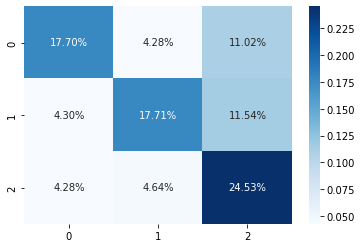

In [ ]:
cf_matrix = confusion_matrix(df1.values.tolist(), df_pred.tolist())
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
df_1 = pd.DataFrame(np.array(v1))
df_2 = pd.DataFrame(np.array(v2))
df = pd.concat([df_1, df_2], axis=1, join='inner')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df1,stratify=df1,test_size=0.33)

#### SVM for DOC to VEC embeddings

In [ ]:
# clf = svm.SVC(kernel='linear') 
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.619


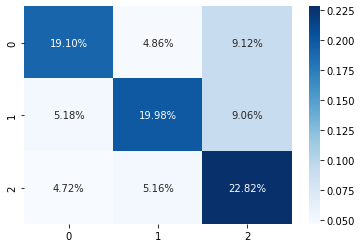

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#### Gaussian Naive Bayes for DOC to VEC Embeddings

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.6205


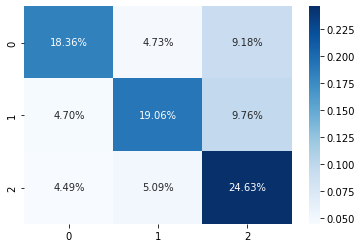

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#### ANN for DOC to VEC Embeddings

In [ ]:
def ann_label(X_train, X_test, y_train, y_test):
  model = Sequential()
  model.add(Dense(20, input_dim=40, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit the keras model on the dataset
  model.fit(X_train, y_train, epochs=100, batch_size=1111)
  # evaluate the keras model
  _, accuracy = model.evaluate(X_train, y_train)
  print('Accuracy: %.2f' % (accuracy*100))
  return model.predict(X_test)

In [ ]:
y_pred=ann_label(X_train, X_test, y_train, y_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.6688


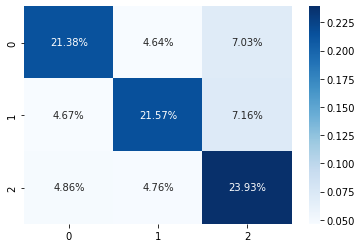

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')